In [ ]:
%tensorflow_version 2.x

In [ ]:
import pandas as pd
link = 'https://github.com/Iamsdt/DLModelDeploy/raw/master/Review2500New.csv'
df = pd.read_csv(link)
df.head()

,Score,Text
0,Poor,This is NOT Disco Dust which is edible and mad...
1,Medium,"PB is a major source of calories, so this is a..."
2,Average,I used to buy the Pillsbury mix but I gave thi...
3,Medium,Decent-tasting beverage.<br /><br />Personally...
4,Good,We like Pop Secret 100 Calorie pop corn. The t...


In [ ]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
df.Text = df.Text.apply(remove_tags)

In [ ]:
df.Text = df.Text.str.lower()

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatization(text):
  doc = nlp(text)
  tokens = [token.text for token in doc]
  lemmas = [token.lemma_ for token in doc]
  a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() or lemma == '-PRON-']
  s = ' '.join(a_lemmas)
  return s

In [ ]:
from tqdm import tqdm

reviews = []
sentences = list(df['Text'])
for sen in tqdm(sentences):
    # reviews.append(lemmatization(sen))
    reviews.append((sen))    

100%|██████████| 25000/25000 [00:00<00:00, 1695298.45it/s]


In [ ]:
di = {
    "Poor" : 1,
    "Average" : 2,
    "Medium" : 3,
    "Good" : 4,
    "Best" : 5
}

labels_data = df.Score.replace(di)

In [ ]:
import numpy as np

y = np.array(list(labels_data))

In [ ]:
reviews[10], y[10]

('i am not muslim, but was interested in this jerky because of its low carb content compared to some other brands of "sweet" jerky out there.  it has a slightly sweet taste and great flavor (spicy...but not hot)!  it is easy to chew and doesn\'t leave your fingers sticky. i wish it came in more economical sizes (6, 9, or 12 oz sizes), but that doesn\'t seem to be the case.  it\'s a great jerky and might just be addictive, which probably makes the 3 ounces bag size a good choice...after the first 3 ounces you have to stop (at least long enough to open another bag)!!!',
 5)

In [ ]:
from keras.preprocessing.text import Tokenizer
from string import punctuation

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 33443 unique tokens.


In [ ]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print('Shape of data tensor:', X.shape)

Shape of data tensor: (25000, 150)


In [ ]:
from sklearn import preprocessing
import keras

# Encode labels
le = preprocessing.LabelEncoder()
le.fit(y)
enc = le.transform(y)
y = keras.utils.to_categorical(enc)

In [ ]:
y[10]

array([0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
df.Score.unique()

array(['Poor', 'Medium', 'Average', 'Good', 'Best'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(22500, 150) (22500, 5)
(2500, 150) (2500, 5)


In [ ]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, BatchNormalization, Bidirectional, Flatten
from tensorflow.keras.models import Sequential

EMBEDDING_DIM = 1000

def create_model(EMBEDDING_DIM = 100):
  return Sequential([
      Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, input_shape=(X_train.shape[1], )),
      LSTM(units=256, return_sequences=True),
      LSTM(units=1024),
      Dense(2048, activation='relu'),
      Dense(5, activation='sigmoid')
  ])

#model = Sequential()
#model.add(Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, input_shape=(X_train.shape[1], )))
#model.add(LSTM(units=256))
#model.add(Dense(1024, activation='relu'))
#model.add(Dense(5, activation='sigmoid'))

#model = create_model()

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

#print(model.summary())

In [ ]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: 10.63.165.138:8470


INFO:tensorflow:Initializing the TPU system: 10.63.165.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

#opt = Adam(learning_rate=0.0001)
#loss = BinaryCrossentropy()

with strategy.scope():
  modelTpu = create_model()
  modelTpu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
modelTpu.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 100)          3344400   
_________________________________________________________________
lstm_10 (LSTM)               (None, 150, 256)          365568    
_________________________________________________________________
lstm_11 (LSTM)               (None, 1024)              5246976   
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 10245     
Total params: 11,066,389
Trainable params: 11,066,389
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# epochs = 3
# batch_size = 64

#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:
epochs = 3
batch_size = 100

history = modelTpu.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Train on 18000 samples, validate on 4500 samples
Epoch 1/3
18000/18000 [==============================] - 26s 1ms/sample - loss: 0.4686 - acc: 0.8044 - val_loss: 0.4534 - val_acc: 0.8064
Epoch 2/3
18000/18000 [==============================] - 20s 1ms/sample - loss: 0.4236 - acc: 0.8126 - val_loss: 0.4286 - val_acc: 0.8104
Epoch 3/3
18000/18000 [==============================] - 20s 1ms/sample - loss: 0.3908 - acc: 0.8176 - val_loss: 0.4195 - val_acc: 0.8114


In [ ]:
accr = modelTpu.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2500/2500 [==============================] - 4s 2ms/sample - loss: 0.4215 - acc: 0.8090
Test set
  Loss: 0.422
  Accuracy: 0.809


In [ ]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['acc'])
  plt.plot(epoch_range, history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

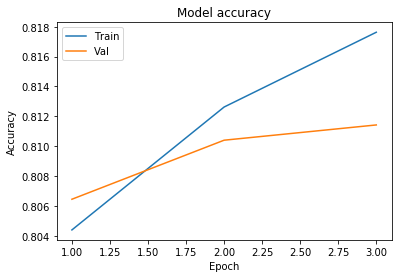

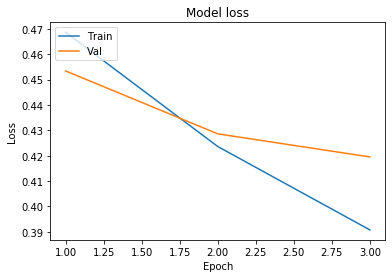

In [ ]:
from  matplotlib import pyplot as plt

plot_learningCurve(history, 3)

## Test

In [ ]:
txt = df.Text [100]

pre = remove_tags(txt)
#pre = lemmatization(pre)
pre

'i was very excited to hear about arctic zero products, as i\'m always looking for lower-calorie, natural snacks to incorporate into my healthy diet.  after checking them out on amazon and reading some good reviews, i headed to the local big-box natural grocery store to buy one of each of the flavors (they\'re slightly more than half the amazon price there).  even the cashier commented that she\'d heard good things about this brand, and that the cookies and cream flavor seemed to be customers\' favorite.after trying this flavor last night, however, i don\'t think i\'ll be buying these again.  as other reviewers have said, the color is different from a typical, off-the-shelf cookies and cream ice cream, although that doesn\'t bother me because i\'m used to all-natural foods being different in color than their synthetic counterparts.  what did bother me, however, was the taste - i would not classify this as overly sweet as some other reviewers have. in fact i\'d classify the flavor as sl

In [ ]:
seq = tokenizer.texts_to_sequences(pre)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
out = model.predict(padded)

In [ ]:
print(out[0])
np.argmax(out[0])

[0.1596175  0.1425085  0.12922378 0.15380354 0.17857064]


4

In [ ]:
df.Score[100]

'Average'

### Test

In [ ]:
classes = list(df.Score.unique())
classes

['Poor', 'Medium', 'Average', 'Good', 'Best']

In [ ]:
def predict(s):
  s = remove_tags(s)
  s = lemmatization(s)
  seq = tokenizer.texts_to_sequences(s)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  out = model.predict(padded)
  print(np.argmax(out[0]))
  return classes[np.argmax(out[0])]

In [ ]:
predict("I love this produt this is rally awesome")

4


'Best'

In [ ]:
predict(df.Text[10])

4


'Best'

In [ ]:
df.Score[10]

'Best'

In [ ]:
predict("I hate this product, just a complete waste of time")

4


'Best'

In [ ]:
pre = 'Hello'
seq = tokenizer.texts_to_sequences(pre)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
out = model.predict(padded)

In [ ]:
classes[np.argmax(out[0])]

'Average'

# Confusion Matric

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_pred ]

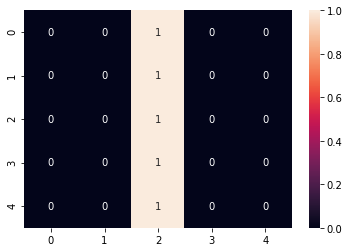

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category, normalize='true')
sns.heatmap(conf_mat, annot=True)

Using Estimator

In [ ]:
import tensorflow as tf

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    df, df["Score"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    df, df["Sentiment"], shuffle=False)


embedded_text_feature_column = hub.text_embedding_column(
    key="Phrase", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=5,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

estimator.train(input_fn=train_input_fn, steps=10000);